In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
!pip install --upgrade numpy
!pip install --force-reinstall gensim
from gensim import corpora
from gensim.models import LdaModel

nltk.download('stopwords')

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Collect reviews
import os

reviews = []
for page in range(1, 11):
    url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{page}/"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    for review_block in soup.find_all('div', {'class': 'text_content'}):
        review_text = review_block.get_text(strip=True)
        reviews.append(review_text)
    time.sleep(1)

df = pd.DataFrame(reviews, columns=['review'])

if not os.path.exists('data'):
    os.makedirs('data')
df.to_csv('data/ba_reviews_raw.csv', index=False)
df.head()

,review
0,✅Trip Verified| I had an appalling experienc...
1,"Not Verified| Good points, the cabin crew, th..."
2,"Not Verified| It was a decent flight, reasona..."
3,✅Trip Verified| I really like flying British...
4,✅Trip Verified| Could not book online the ni...


In [5]:
#Clean text data
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

df['cleaned_review'] = df['review'].apply(clean_text)
df.head()

,review,cleaned_review
0,✅Trip Verified| I had an appalling experienc...,trip verified appalling experience british air...
1,"Not Verified| Good points, the cabin crew, th...",verified good points cabin crew helpful profes...
2,"Not Verified| It was a decent flight, reasona...",verified decent flight reasonable comfortable ...
3,✅Trip Verified| I really like flying British...,trip verified really like flying british airwa...
4,✅Trip Verified| Could not book online the ni...,trip verified could book online night system a...


In [6]:
#Sentiment analysis
df['sentiment'] = df['cleaned_review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
df['sentiment_label'].value_counts()

,count
sentiment_label,
Positive,62
Negative,36
Neutral,2


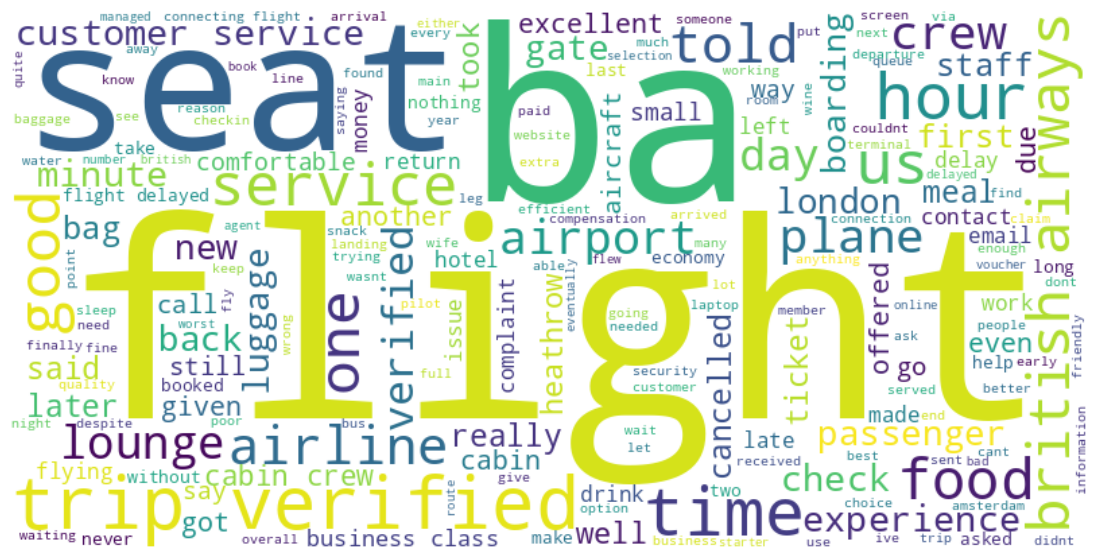

In [7]:
# Word Cloud
text = ' '.join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
# Topic Modeling
texts = [text.split() for text in df['cleaned_review']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.020*"flight" + 0.012*"ba" + 0.009*"would" + 0.009*"us" + 0.008*"verified" + 0.007*"trip" + 0.007*"service" + 0.006*"back" + 0.005*"customer" + 0.005*"luggage"')
(1, '0.015*"good" + 0.010*"ba" + 0.009*"cabin" + 0.009*"time" + 0.008*"flight" + 0.007*"first" + 0.007*"food" + 0.006*"verified" + 0.006*"crew" + 0.006*"excellent"')
(2, '0.029*"flight" + 0.014*"verified" + 0.013*"ba" + 0.012*"british" + 0.011*"airways" + 0.010*"trip" + 0.009*"service" + 0.007*"hours" + 0.007*"cancelled" + 0.006*"crew"')
(3, '0.015*"ba" + 0.015*"flight" + 0.009*"would" + 0.008*"service" + 0.007*"verified" + 0.007*"told" + 0.006*"trip" + 0.006*"get" + 0.005*"seat" + 0.005*"staff"')
(4, '0.013*"flight" + 0.009*"verified" + 0.009*"food" + 0.009*"trip" + 0.007*"one" + 0.007*"seat" + 0.007*"crew" + 0.005*"good" + 0.005*"bag" + 0.005*"passengers"')


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/review_wordcloud.png'

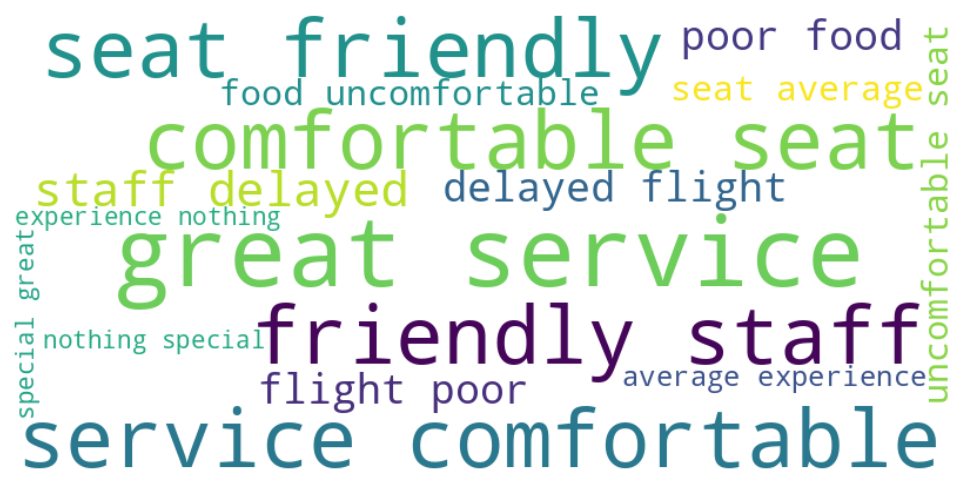

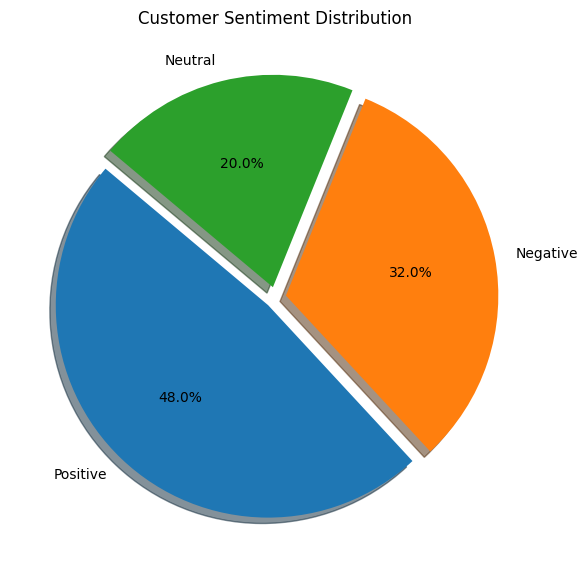

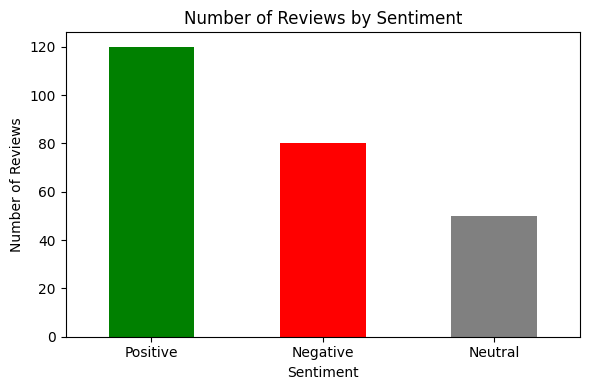

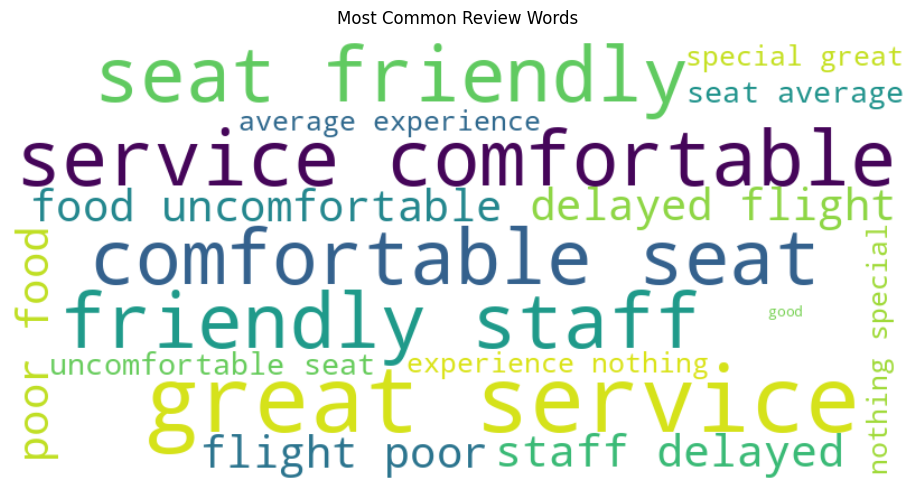

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Simulate cleaned review data
sentiment_labels = ['Positive'] * 120 + ['Negative'] * 80 + ['Neutral'] * 50
reviews = [
    "great service comfortable seat friendly staff",
    "delayed flight poor food uncomfortable seat",
    "average experience nothing special"
] * (250 // 3) + ["good flight"]

reviews = reviews[:250]

# Create DataFrame
df = pd.DataFrame({
    'sentiment_label': sentiment_labels,
    'cleaned_review': reviews
})

#  Sentiment Distribution Pie Chart
plt.figure(figsize=(6, 6))
df['sentiment_label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    explode=[0.05]*3,
    shadow=True
)
plt.title('Customer Sentiment Distribution')
plt.ylabel('')
plt.tight_layout()
plt.savefig('sentiment_pie_chart.png')
plt.show()

# Sentiment Count Bar Chart
plt.figure(figsize=(6, 4))
df['sentiment_label'].value_counts().plot(
    kind='bar',
    color=['green', 'red', 'gray']
)
plt.title('Number of Reviews by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('sentiment_bar_chart.png')
plt.show()

#  Word Cloud from Review Text
text = ' '.join(df['cleaned_review'])
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Review Words')
plt.tight_layout()
plt.savefig('review_wordcloud.png')
plt.show()
